In [4]:
from pycaret.datasets import get_data
from pycaret.clustering import *
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.cluster import KMeans, AgglomerativeClustering, Birch
from sklearn.metrics import silhouette_score
from scipy.spatial.distance import cdist
from scipy.cluster.hierarchy import linkage, dendrogram
from sklearn.datasets import load_wine
from sklearn.preprocessing import StandardScaler, normalize
from sklearn.decomposition import PCA

import pandas as pd
from sklearn.datasets import load_wine
from pycaret.clustering import *
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score

,Age,Income,SpendingScore,Savings
0,58,77769,0.791329,6559.829923
1,59,81799,0.791082,5417.661426
2,62,74751,0.702657,9258.992965
3,59,74373,0.765680,7346.334504
4,87,17760,0.348778,16869.507130


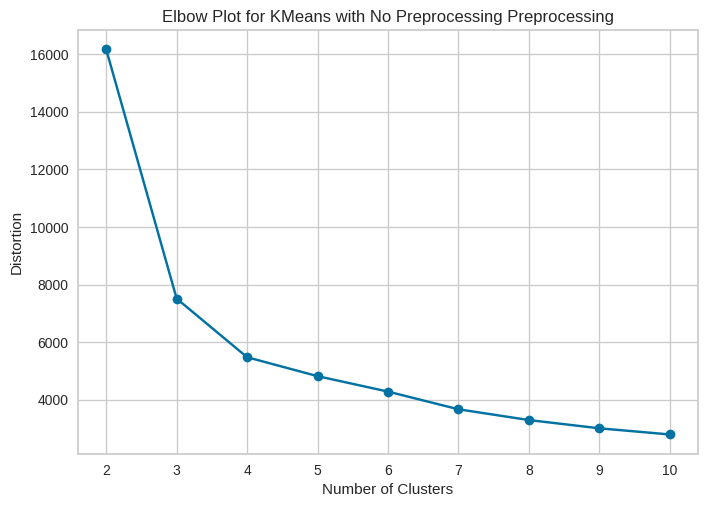

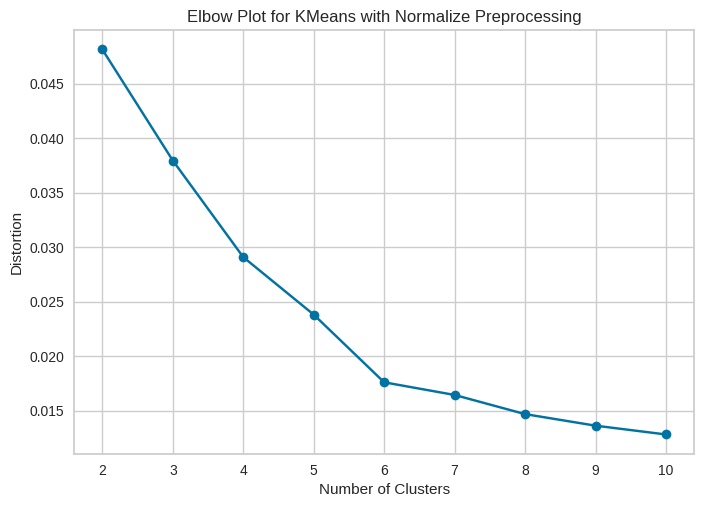

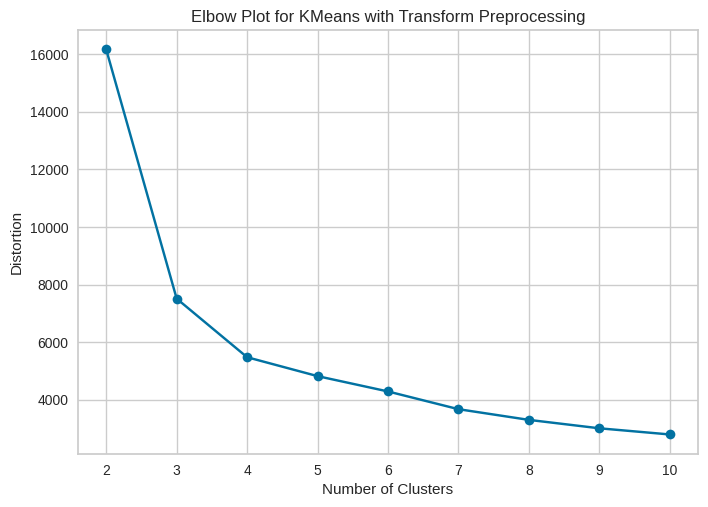

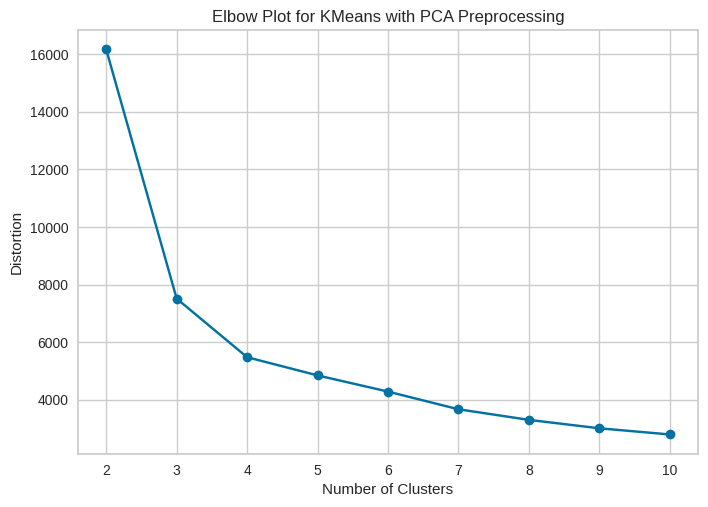

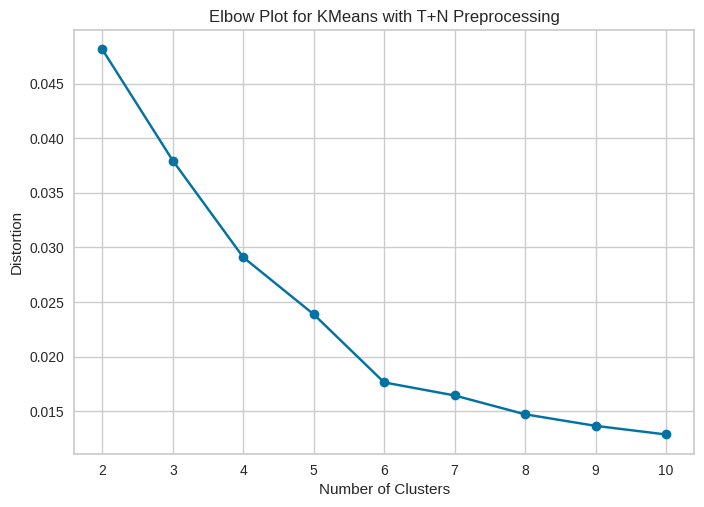

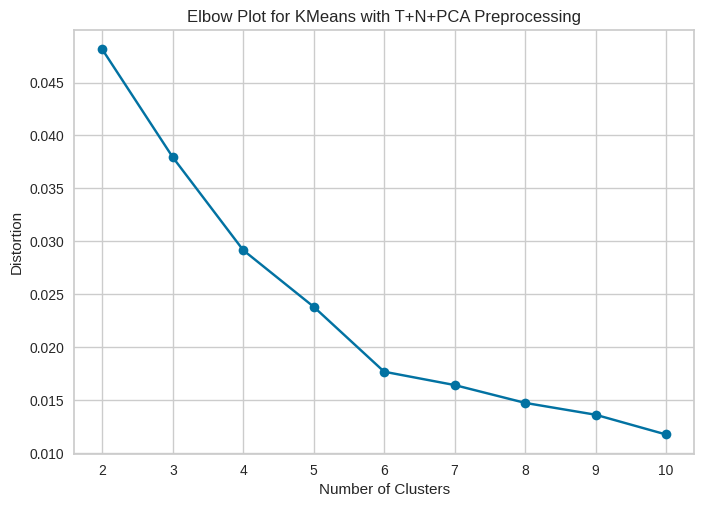

In [5]:

jewelleryDataSet = get_data("jewellery")

X = jewelleryDataSet

# Define preprocessing approaches
preprocessing = {
    'No Preprocessing': lambda x: x,
    'Normalize': normalize,
    'Transform': lambda x: x,  # Replace with your own transformation function
    'PCA': lambda x: PCA(n_components=2).fit_transform(x),
    'T+N': lambda x: normalize(x),
    'T+N+PCA': lambda x: PCA(n_components=2).fit_transform(normalize(x))
}

# Define the number of clusters for the elbow plot
clusters_range = range(2, 11)

# Generate elbow plots for KMeans, Hierarchical, and Birch
for model_name, model in [('KMeans', KMeans()), ('Hierarchical', linkage), ('Birch', Birch())]:
    for preprocess_column, preprocess_func in preprocessing.items():
        X_preprocessed = preprocess_func(X)

        if model_name == 'KMeans':
            distortions = []
            for cluster in clusters_range:
                kmeans = KMeans(n_clusters=cluster)
                kmeans.fit(X_preprocessed)
                distortions.append(sum(np.min(cdist(X_preprocessed, kmeans.cluster_centers_, 'euclidean'), axis=1)) / X_preprocessed.shape[0])

            # Plot the elbow plot for KMeans
            plt.plot(clusters_range, distortions, marker='o')
            plt.title(f'Elbow Plot for {model_name} with {preprocess_column} Preprocessing')
            plt.xlabel('Number of Clusters')
            plt.ylabel('Distortion')
            plt.show()



In [6]:
# Load wine dataset
jewelleryDataSet = get_data("jewellery")

data = jewelleryDataSet

# Define preprocessing approaches using PyCaret
preprocessing_pycaret = {
    'No Preprocessing': None,
    'Normalize': 'normalize',
    'Transform': 'transformation',
    'PCA': 'pca',
    'T+N': ['normalize', 'transformation'],
    'T+N+PCA': ['normalize', 'transformation', 'pca']
}

# Define clustering algorithms using PyCaret with corresponding model names
clustering_algorithms = {
    'kmeans': 'K-Means',
    'hclust': 'Hierarchical',
    'birch': 'Birch'
}

# Create DataFrames to store the results for each algorithm
index = ['Silhouette', 'Calinski-Harabasz', 'Davies-Bouldin']
columns = pd.MultiIndex.from_product([['No Preprocessing', 'Normalize', 'Transform', 'PCA', 'T+N', 'T+N+PCA'], ['c=3', 'c=4', 'c=5']], names=['Preprocessing', 'Clusters'])
results_df = pd.DataFrame(index=index, columns=columns)

# Perform clustering for each combination of preprocessing, algorithm, and clusters using PyCaret
for preprocess_column, preprocess_steps in preprocessing_pycaret.items():
    for algorithm, model_name in clustering_algorithms.items():
        print(f"Model name: {model_name} and Preprocessing used: {preprocess_column}")
        for c in columns.get_level_values('Clusters').unique():
            print(c)
            # Setup PyCaret clustering
            setup(data, normalize=preprocess_steps, transformation=preprocess_steps, verbose=False, pca=preprocess_steps)

            # Create and evaluate the clustering model

            model = create_model(algorithm, num_clusters=int(c[-1]))
            prediction = assign_model(model)

            # Calculate clustering metrics
            labels_column = 'Cluster'  # Adjusted labels column name
            silhouette_score_val = silhouette_score(data, prediction[labels_column])
            calinski_harabasz_index_val = calinski_harabasz_score(data, prediction[labels_column])
            davies_bouldin_index_val = davies_bouldin_score(data, prediction[labels_column])

            # Update the results DataFrame with model name
            results_df.loc[:, (f'{model_name} - {preprocess_column}', c)] = [silhouette_score_val, calinski_harabasz_index_val, davies_bouldin_index_val]



,Age,Income,SpendingScore,Savings
0,58,77769,0.791329,6559.829923
1,59,81799,0.791082,5417.661426
2,62,74751,0.702657,9258.992965
3,59,74373,0.765680,7346.334504
4,87,17760,0.348778,16869.507130


Model name: K-Means and Preprocessing used: No Preprocessing
c=3


,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.7393,3567.5370,0.3435,0,0,0


Processing:   0%|          | 0/3 [00:00<?, ?it/s]

c=4


,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.7207,5011.8115,0.4114,0,0,0


Processing:   0%|          | 0/3 [00:00<?, ?it/s]

c=5


,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.6777,4685.1995,0.4596,0,0,0


Processing:   0%|          | 0/3 [00:00<?, ?it/s]

Model name: Hierarchical and Preprocessing used: No Preprocessing
c=3


,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.7391,3542.6251,0.3407,0,0,0


Processing:   0%|          | 0/3 [00:00<?, ?it/s]

c=4


,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.7060,4827.2243,0.4339,0,0,0


Processing:   0%|          | 0/3 [00:00<?, ?it/s]

c=5


,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.6908,4516.4327,0.4650,0,0,0


Processing:   0%|          | 0/3 [00:00<?, ?it/s]

Model name: Birch and Preprocessing used: No Preprocessing
c=3


,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.7391,3542.6251,0.3407,0,0,0


Processing:   0%|          | 0/3 [00:00<?, ?it/s]

c=4


,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.7060,4827.2243,0.4339,0,0,0


Processing:   0%|          | 0/3 [00:00<?, ?it/s]

c=5


,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.6908,4516.4327,0.4650,0,0,0


Processing:   0%|          | 0/3 [00:00<?, ?it/s]

Model name: K-Means and Preprocessing used: Normalize
c=3


,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.6912,1016.4677,0.5410,0,0,0


Processing:   0%|          | 0/3 [00:00<?, ?it/s]

c=4


,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.7544,1467.4682,0.3868,0,0,0


Processing:   0%|          | 0/3 [00:00<?, ?it/s]

c=5


,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.8063,3503.4024,0.2748,0,0,0


Processing:   0%|          | 0/3 [00:00<?, ?it/s]

Model name: Hierarchical and Preprocessing used: Normalize
c=3


,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.6912,1016.4677,0.5410,0,0,0


Processing:   0%|          | 0/3 [00:00<?, ?it/s]

c=4


,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.7544,1467.4682,0.3868,0,0,0


Processing:   0%|          | 0/3 [00:00<?, ?it/s]

c=5


,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.8063,3503.4024,0.2748,0,0,0


Processing:   0%|          | 0/3 [00:00<?, ?it/s]

Model name: Birch and Preprocessing used: Normalize
c=3


,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.6912,1016.4677,0.5410,0,0,0


Processing:   0%|          | 0/3 [00:00<?, ?it/s]

c=4


,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.7312,1114.5675,0.3990,0,0,0


Processing:   0%|          | 0/3 [00:00<?, ?it/s]

c=5


,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.8063,3503.4024,0.2748,0,0,0


Processing:   0%|          | 0/3 [00:00<?, ?it/s]

Model name: K-Means and Preprocessing used: Transform
c=3


,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.6912,1016.4677,0.5410,0,0,0


Processing:   0%|          | 0/3 [00:00<?, ?it/s]

c=4


,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.7544,1467.4682,0.3868,0,0,0


Processing:   0%|          | 0/3 [00:00<?, ?it/s]

c=5


,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.8063,3503.4024,0.2748,0,0,0


Processing:   0%|          | 0/3 [00:00<?, ?it/s]

Model name: Hierarchical and Preprocessing used: Transform
c=3


,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.6912,1016.4677,0.5410,0,0,0


Processing:   0%|          | 0/3 [00:00<?, ?it/s]

c=4


,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.7544,1467.4682,0.3868,0,0,0


Processing:   0%|          | 0/3 [00:00<?, ?it/s]

c=5


,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.8063,3503.4024,0.2748,0,0,0


Processing:   0%|          | 0/3 [00:00<?, ?it/s]

Model name: Birch and Preprocessing used: Transform
c=3


,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.6912,1016.4677,0.5410,0,0,0


Processing:   0%|          | 0/3 [00:00<?, ?it/s]

c=4


,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.7312,1114.5675,0.3990,0,0,0


Processing:   0%|          | 0/3 [00:00<?, ?it/s]

c=5


,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.8063,3503.4024,0.2748,0,0,0


Processing:   0%|          | 0/3 [00:00<?, ?it/s]

Model name: K-Means and Preprocessing used: PCA
c=3


,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.6912,1016.4677,0.5410,0,0,0


Processing:   0%|          | 0/3 [00:00<?, ?it/s]

c=4


,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.7544,1467.4682,0.3868,0,0,0


Processing:   0%|          | 0/3 [00:00<?, ?it/s]

c=5


,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.8063,3503.4024,0.2748,0,0,0


Processing:   0%|          | 0/3 [00:00<?, ?it/s]

Model name: Hierarchical and Preprocessing used: PCA
c=3


,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.6912,1016.4677,0.5410,0,0,0


Processing:   0%|          | 0/3 [00:00<?, ?it/s]

c=4


,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.7544,1467.4682,0.3868,0,0,0


Processing:   0%|          | 0/3 [00:00<?, ?it/s]

c=5


,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.8063,3503.4024,0.2748,0,0,0


Processing:   0%|          | 0/3 [00:00<?, ?it/s]

Model name: Birch and Preprocessing used: PCA
c=3


,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.6912,1016.4677,0.5410,0,0,0


Processing:   0%|          | 0/3 [00:00<?, ?it/s]

c=4


,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.7312,1114.5675,0.3990,0,0,0


Processing:   0%|          | 0/3 [00:00<?, ?it/s]

c=5


,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.8063,3503.4024,0.2748,0,0,0


Processing:   0%|          | 0/3 [00:00<?, ?it/s]

Model name: K-Means and Preprocessing used: T+N
c=3


,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.6912,1016.4677,0.5410,0,0,0


Processing:   0%|          | 0/3 [00:00<?, ?it/s]

c=4


,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.7544,1467.4682,0.3868,0,0,0


Processing:   0%|          | 0/3 [00:00<?, ?it/s]

c=5


,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.8063,3503.4024,0.2748,0,0,0


Processing:   0%|          | 0/3 [00:00<?, ?it/s]

Model name: Hierarchical and Preprocessing used: T+N
c=3


,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.6912,1016.4677,0.5410,0,0,0


Processing:   0%|          | 0/3 [00:00<?, ?it/s]

c=4


,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.7544,1467.4682,0.3868,0,0,0


Processing:   0%|          | 0/3 [00:00<?, ?it/s]

c=5


,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.8063,3503.4024,0.2748,0,0,0


Processing:   0%|          | 0/3 [00:00<?, ?it/s]

Model name: Birch and Preprocessing used: T+N
c=3


,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.6912,1016.4677,0.5410,0,0,0


Processing:   0%|          | 0/3 [00:00<?, ?it/s]

c=4


,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.7312,1114.5675,0.3990,0,0,0


Processing:   0%|          | 0/3 [00:00<?, ?it/s]

c=5


,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.8063,3503.4024,0.2748,0,0,0


Processing:   0%|          | 0/3 [00:00<?, ?it/s]

Model name: K-Means and Preprocessing used: T+N+PCA
c=3


,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.6912,1016.4677,0.5410,0,0,0


Processing:   0%|          | 0/3 [00:00<?, ?it/s]

c=4


,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.7544,1467.4682,0.3868,0,0,0


Processing:   0%|          | 0/3 [00:00<?, ?it/s]

c=5


,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.8063,3503.4024,0.2748,0,0,0


Processing:   0%|          | 0/3 [00:00<?, ?it/s]

Model name: Hierarchical and Preprocessing used: T+N+PCA
c=3


,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.6912,1016.4677,0.5410,0,0,0


Processing:   0%|          | 0/3 [00:00<?, ?it/s]

c=4


,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.7544,1467.4682,0.3868,0,0,0


Processing:   0%|          | 0/3 [00:00<?, ?it/s]

c=5


,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.8063,3503.4024,0.2748,0,0,0


Processing:   0%|          | 0/3 [00:00<?, ?it/s]

Model name: Birch and Preprocessing used: T+N+PCA
c=3


,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.6912,1016.4677,0.5410,0,0,0


Processing:   0%|          | 0/3 [00:00<?, ?it/s]

c=4


,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.7312,1114.5675,0.3990,0,0,0


Processing:   0%|          | 0/3 [00:00<?, ?it/s]

c=5


,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.8063,3503.4024,0.2748,0,0,0


Processing:   0%|          | 0/3 [00:00<?, ?it/s]

In [7]:
results_df = results_df.dropna(axis=1)
display(results_df)
# Save the results to a CSV file
results_df.to_csv('pycaret_results.csv', index=True)

Preprocessing     K-Means - No Preprocessing                            \
Clusters                                 c=3          c=4          c=5   
Silhouette                          0.739317     0.720723     0.677713   
Calinski-Harabasz                3567.536978  5011.811464  4685.199472   
Davies-Bouldin                      0.343528     0.411354     0.459642   

Preprocessing     Hierarchical - No Preprocessing                            \
Clusters                                      c=3          c=4          c=5   
Silhouette                               0.739067     0.705973     0.690839   
Calinski-Harabasz                     3542.625083  4827.224245  4516.432670   
Davies-Bouldin                           0.340738     0.433863     0.464950   

Preprocessing     Birch - No Preprocessing                            \
Clusters                               c=3          c=4          c=5   
Silhouette                        0.739067     0.705973     0.690839   
Calinski-Harabasz              3542.625083  4827.224245  4516.432670   
Davies-Bouldin                    0.340738     0.433863     0.464950   

Preprocessing     K-Means - Normalize  ...  Birch - T+N K-Means - T+N+PCA  \
Clusters                          c=3  ...          c=5               c=3   
Silhouette                   0.558859  ...     0.661777          0.558859   
Calinski-Harabasz          928.959351  ...  4124.203772        928.959351   
Davies-Bouldin               0.914221  ...     0.510695          0.914221   

Preprocessing                               Hierarchical - T+N+PCA  \
Clusters                   c=4          c=5                    c=3   
Silhouette            0.713829     0.661777               0.558859   
Calinski-Harabasz  4449.578275  4124.203772             928.959351   
Davies-Bouldin        0.388792     0.510695               0.914221   

Preprocessing                               Birch - T+N+PCA              \
Clusters                   c=4          c=5             c=3         c=4   
Silhouette            0.713829     0.661777        0.558859    0.450624   
Calinski-Harabasz  4449.578275  4124.203772      928.959351  643.827251   
Davies-Bouldin        0.388792     0.510695        0.914221    0.889482   

Preprocessing                   
Clusters                   c=5  
Silhouette            0.661777  
Calinski-Harabasz  4124.203772  
Davies-Bouldin        0.510695  

[3 rows x 54 columns]